In [1]:
import xarray as xr
import numpy as np
import tools
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from datetime import datetime 
from datetime import timedelta

import scipy.interpolate as interp

scrip.so not found. Remapping function will not be available


# Assessment of the OSSE simulations

An assesment of the OSSE simulations will be done here. We will try to perform it in a analogue way to the one done for the OSE, where real observations were used for assimilation and assesment.

- SLA: The value of the NR at the position of the regular satellite tracks will be extracted and compared to the simulations.
    
- SST: The NR surface temperature field will be considered and subsampled, reducing the resolution to 10 km by picking one of every four observations both in vertical and horizontal.
    
- ARGO: Temperature and salinity profiles at position of the buoys during the experiment will be extracted from NR and simulations and compared
    
- TS profiles will algo be assesed in areas of the domain distant from assimialt4ed observations. This way, the capabilities of the model will also be assesed.

- HFR: The data samples taken apart for validation will be used for this purpose

## SLA

In [2]:
import DA_toolbox as da

#### Load Observations

Observations will only be used to get the position of them along the track and be able to extract model observations at the same position

In [3]:
ds = da.get_altimetry_data( '20140925',  'rep_along-track_sla', timewindow=10, limits = [-6, 9.2, 35, 44.5])



 Loading SLA observations for 25-Sep-2014. Time window = 10 days

     OSTM/Jason-2  Number obs = 345
     Haiyang-2A  Number obs = 300
     Cryosat-2  Number obs = 399
     AltiKa  Number obs = 329

   Total number of observations = 1373


### Calcualte RMSD

For each of the different experiments the RMSD is calculated for every day of simulation, interpolating the SLA field to the postion of the observations. The positions will be considered the same all along the experiment

In [4]:
import scipy.interpolate as interp
import skill_metrics as sm

# Define initial and end date
date = datetime(2014,9,21)
date_end = datetime(2014,10,19)

# Experiment names from which to extract equivalents to observations and to calculate RMSD
exp_names = ['NOASSIM', 'generic_nudging', 'all_future_nudging', 'all_actual_nudging', 'generic_nonudging', 'all_future_nonudging', 'all_actual_nonudging']
#exp_names = ['NOASSIM', 'generic_nudging', 'all_future_nudging', 'generic_nonudging', 'all_future_nonudging', 'all_actual_nonudging']

# number of days of simulation
ndays = (date_end - date).days


# Initialize empty dictionary and arrays
rmsd = {}
sla_obs_total = {}  # array containing all observations (concatenate each day obs)
sla_wmop_total = {}  # array containing all wmop obs
for exp in exp_names:
    rmsd[exp] = np.empty(ndays)
    sla_obs_total[exp] = np.array([])
    sla_wmop_total[exp] = np.array([])

    
# WMOP MDT
file_mdt_wmop = '/home/modelling/data/WMOP/WMOP_HINDCAST/Outputs/HINDCAST_MFS_v17/7year_mean/roms_WMOP_HINDCAST_7yearmean.nc'
ds_mdt_wmop = xr.open_dataset(file_mdt_wmop)

# WMOP MDT
file_mdt_nr = '/data/modelling/WMOP_ASSIM/Inputs/roms_WMOP_HINDCAST_synthetic_201505_201704_mean.nc'
ds_mdt_nr = xr.open_dataset(file_mdt_nr)

    
# Loop over days
for i in range(ndays):
    
    strdate = date.strftime('%Y%m%d')    
    
    # Loop over different simulations
    for exp in exp_names: 

        if exp in ['NOASSIM']:
            path_wmop = path_wmop = '/home/modelling/data/workdir_2/HFR_DA/HFR_{0}_Oct2014'.format(exp)
        else:
            path_wmop = '/DATA/jhernandez/ROMS/Outputs/HFR_{0}_Oct2014_OSSE/'.format(exp)
            
        file_wmop = '{0}/roms_WMOP_ASSIM_{1}_avg.nc'.format(path_wmop, strdate)
        file_nr = '/home/modelling/data/WMOP/WMOP_FORECAST/Outputs/FORECAST_CMEMS_RESTARTS/forecast_scratch//roms_WMOP_FORECAST_{0}_his.nc'.format(strdate)

        ds_wmop = xr.open_dataset(file_wmop)
        ds_nr = xr.open_dataset(file_nr)
      
        # Interpolate WMOP
        sla1 = ds_wmop.zeta[0,:,:].values - ds_mdt_wmop.zeta[0,:,:].values
        sla1[np.isnan(sla1)] = 10000
        fz1 = interp.interp2d(ds_wmop.lon_rho[1,:].values, ds_wmop.lat_rho[:,1].values, sla1, kind='linear')

        sla_interp1 = [fz1(ds.longitude[i], ds.latitude[i])[0] for i in range(len(ds.longitude))]
        sla_interp1 = np.array(sla_interp1)

        # Interpolate NR
        sla2 = ds_nr.zeta[0,:,:].values - ds_mdt_nr.zeta[0,:,:].values
        sla2[np.isnan(sla2)] = 10000
        fz2 = interp.interp2d(ds_nr.lon_rho[1,:].values, ds_nr.lat_rho[:,1].values, sla2, kind='linear')

        sla_interp2 = [fz2(ds.longitude[i], ds.latitude[i])[0] for i in range(len(ds.longitude))]
        sla_interp2 = np.array(sla_interp2)        

        # Compute RMSD
        rmsd[exp][i] = sm.rmsd(sla_interp2, sla_interp1)
        
        sla_obs_total[exp] = np.concatenate((sla_obs_total[exp], sla_interp2))
        sla_wmop_total[exp] = np.concatenate((sla_wmop_total[exp], sla_interp1))
       # print(rmsd[exp][i])
    
    #print('')
    date = date + timedelta(days=1)
    
print('DONE!!!')



DONE!!!


In [5]:
file_wmop

'/DATA/jhernandez/ROMS/Outputs/HFR_all_actual_nonudging_Oct2014_OSSE_v2//roms_WMOP_ASSIM_20141018_avg.nc'

In [5]:
t0 = datetime(2014,9,21)
t = [t0 + timedelta(days=i) for i in range(31)]
xt = range(0,31,3)
tt = [time.strftime('%d/%m/%Y') for time in t]

In [6]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

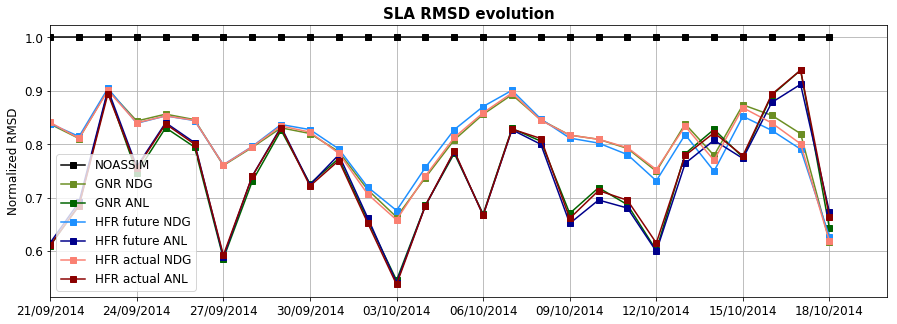

In [8]:
# Define experiments and labels for legend
exp_names = ['NOASSIM', 'generic_nudging', 'generic_nonudging', 'all_future_nudging', 'all_future_nonudging', 'all_actual_nudging', 'all_actual_nonudging']
labels = ['NOASSIM', 'GNR NDG', 'GNR ANL', 'HFR future NDG', 'HFR future ANL', 'HFR actual NDG', 'HFR actual ANL']
colors = ['black', 'olivedrab', 'darkgreen', 'dodgerblue', 'darkblue', 'salmon', 'darkred']

# Subset
subset = [1,3,5]
#subset = [2,4,6]
subset = [0,1,2,3,4,5,6]
exp_names = [exp_names[i] for i in subset];  labels = [labels[i] for i in subset]; colors = [colors[i] for i in subset]


fig = plt.figure(figsize=(15,5))

for i, exp in enumerate(exp_names):
    
    plt.plot(rmsd[exp] / rmsd['NOASSIM'], marker='s', linestyle='-', color=colors[i])
plt.legend(labels)
plt.xticks(ticks=list(xt),labels=tt[0:-1:3])
plt.grid(True)
plt.xlim((0,29))
plt.ylabel('Normalized RMSD')
plt.title('SLA RMSD evolution', fontsize=15, fontweight='bold')
plt.show()

In [45]:
fig.savefig('/home/jhernandez/Escritorio/OSSE_v2/rmsd_evolution_SLA_OSSE_ndg.png', dpi=250)

In [9]:
for exp in exp_names[0:]:
    print('{0}: '.format(exp))
    print(np.mean(rmsd[exp], axis=0)/ np.mean(rmsd['NOASSIM'], axis=0))
    print('')

NOASSIM: 
1.0

generic_nudging: 
0.8136518391080694

generic_nonudging: 
0.7480935898036188

all_future_nudging: 
0.8113883864625819

all_future_nonudging: 
0.7465606001715114

all_actual_nudging: 
0.8120335684100426

all_actual_nonudging: 
0.7495798328901139



## Taylor Diagram

In [61]:
# Define experiments and labels for legend
exp_names = ['NOASSIM', 'generic_nudging', 'generic_nonudging', 'all_future_nudging', 'all_future_nonudging', 'all_actual_nudging', 'all_actual_nonudging']
labels = ['NOASSIM', 'GNR NDG', 'GNR ANL', 'HFR future NDG', 'HFR future ANL', 'HFR actual NDG', 'HFR actual ANL']
colors = ['black', 'olivedrab', 'darkgreen', 'dodgerblue', 'darkblue', 'salmon', 'darkred']

# Subset
#subset = [0,1,3,5]
#subset = [0,2,4,6]
subset = [0,1,2,3,4,5,6]
exp_names = [exp_names[i] for i in subset];  labels = [labels[i] for i in subset]; colors = [colors[i] for i in subset]

sdev = []; crmsd = []; ccoef = []; taylor_stats = {}

# Calculate taylor diagram stats for the different experiments selcted
for e in exp_names:
    taylor_stats[e] = sm.taylor_statistics(sla_wmop_total[e], sla_obs_total[e])
    sdev.append(taylor_stats[e]['sdev'][1])
    crmsd.append(taylor_stats[e]['crmsd'][1])
    ccoef.append(taylor_stats[e]['ccoef'][1])

# Add reference value and convert to array
sdev = np.array([taylor_stats['NOASSIM']['sdev'][0]] + sdev)
crmsd = np.array([taylor_stats['NOASSIM']['crmsd'][0]] + crmsd)
ccoef = np.array([taylor_stats['NOASSIM']['ccoef'][0]] + ccoef)

In [62]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

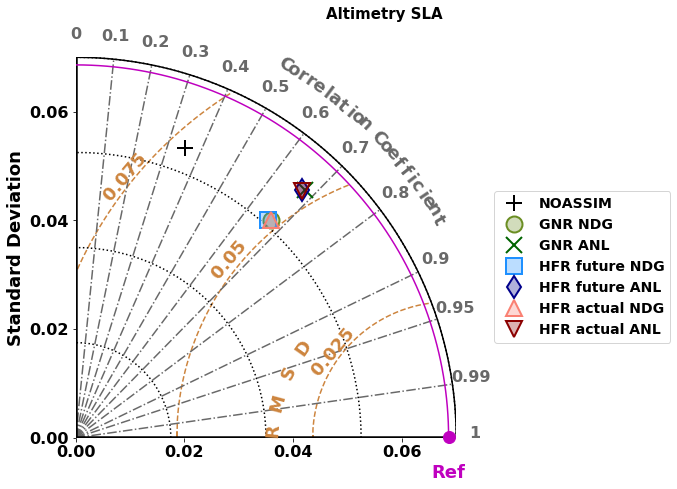

In [63]:
label = ['SLA'] + labels

fig_taylor_sla = plt.figure(num=1, figsize=(12,7))
sm.taylor_diagram(sdev,crmsd,ccoef, markerLabel=label,  markerLabelColor = 'r', markerDisplayed = 'marker',
                      markerLegend = 'on', markercolor = colors,
                      styleOBS = '-', colOBS = 'm', markerobs = 'o',
                      markerSize = 16, tickRMS = [0.025, 0.05, 0.075], 
                      colRMS = 'peru', colCOR = 'dimgrey',
                      tickRMSangle = 140, showlabelsRMS = 'on', axismax=0.07,
                      titleRMS = 'on', titleOBS = 'Ref', checkstats = 'on', alpha=0.3)#, overlay=True)

plt.suptitle('Altimetry SLA', fontsize=15, fontweight='bold')
plt.show()

In [57]:
fig_taylor_sla.savefig('/home/jhernandez/Escritorio/OSSE_v2/taylor_diagram_SLA_OSSE_all.png', dpi=250)

/DATA/jhernandez/Softs/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


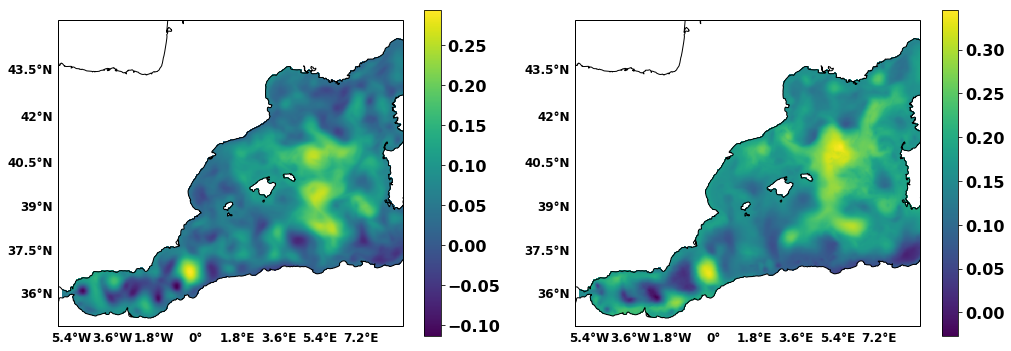

In [30]:
plt.figure(figsize=(17,6))

ax, gl = tools.make_map(continents=False, subplot_dim=121)
plt.pcolormesh(ds_wmop.lon_rho, ds_wmop.lat_rho, ds_wmop.zeta[0,:,:] - ds_mdt_wmop.zeta[0,:,:], transform=gl.crs)
plt.colorbar()

ax, gl = tools.make_map(continents=False, subplot_dim=122)
plt.pcolormesh(ds_nr.lon_rho, ds_nr.lat_rho, ds_nr.zeta[0,:,:] - ds_mdt_nr.zeta[0,:,:], transform=gl.crs)
plt.colorbar()

plt.show()

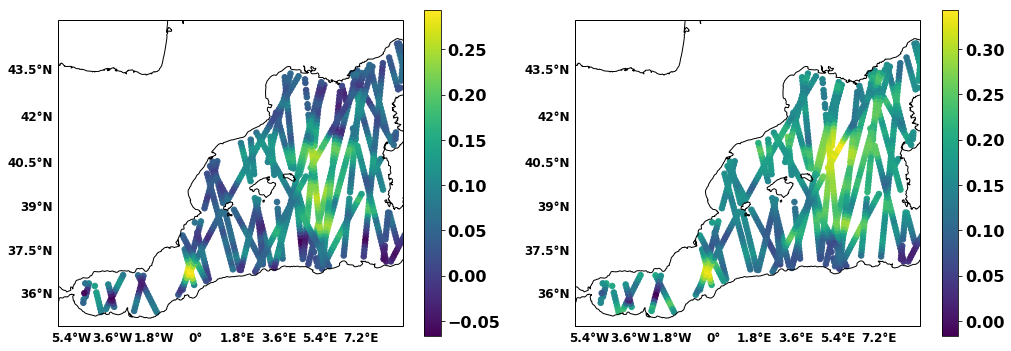

In [31]:
plt.figure(figsize=(17,6))

ax, gl = tools.make_map(continents=False, subplot_dim=121)
plt.scatter(ds.longitude, ds.latitude, 30, sla_interp1, transform=gl.crs)
plt.colorbar()

ax, gl = tools.make_map(continents=False, subplot_dim=122)
plt.scatter(ds.longitude, ds.latitude, 30, sla_interp2, transform=gl.crs)
plt.colorbar()

plt.show()